# NLP Exploratory Data Analysis (EDA)

This notebook explores the required steps required for a Natural Language Processing (NLP) application. This includes:
- Section 1 - Text Cleaning
    - Spelling Correction
- Section 2 - Preprocessing
    - Sentence Segmentation (not applicable in this case) & Tokenization
    - Stop word removal
    - Stemming & Lemmatization
- Section 3 - Feature Engineering
    - Bag-of-Words
    - Ngram-of-Words
    - Embeddings

**Insights:**
- The dataset is quite balanced (57/43)
- Location require extensive preprocessing. One of the approaches might be dropping those below certain count, as it can be considered polluted records.
- There seem to be a considerable amount of tweets with links

In [1]:
import os
import sys
import pandas as pd

# NLP Preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLP Viz
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Data Modelling

# Monitoring progress
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

nltk.download('stopwords')

config = {}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcachosoblechero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Load dataset and basic counts

In [2]:
# Load dataset
input_path = "../input"
raw_tweets = pd.read_csv(os.path.join(input_path, "train.csv")).set_index(['id'])
raw_tweets.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
(raw_tweets.target.value_counts() / len(raw_tweets)) * 100.0

0    57.034021
1    42.965979
Name: target, dtype: float64

In [4]:
raw_tweets.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

# 2. Text Preprocessing

Convert the text into a tokenized version by and preprocess it, lowercasing all words, removing stop words and performing stemming and lemmatization.
Lastly, I convert each label to a wordcloud

In [5]:
# Use Twitter Tokenizer to tokenize tweets
tokenizer = TweetTokenizer()

# Tokenize raw tweets
raw_tweets['twitterTokens'] = raw_tweets.apply(lambda x: tokenizer.tokenize(x.text.lower()), axis=1)
raw_tweets.head()

,keyword,location,text,target,twitterTokens
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart..."
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]"
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al..."


In [6]:
# Remove stop words
english_stopwords = set(stopwords.words('english'))
raw_tweets['twitterTokens_noStop'] = raw_tweets.twitterTokens.apply(lambda x: [i for i in x if i not in english_stopwords])

# Perform stemming
ps = PorterStemmer()
raw_tweets['twitterTokens_Stem'] = raw_tweets.twitterTokens_noStop.apply(lambda x: [ps.stem(i) for i in x])

In [7]:
raw_tweets.head()

,keyword,location,text,target,twitterTokens,twitterTokens_noStop,twitterTokens_Stem
id,,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","[deed, reason, #earthquak, may, allah, forgiv,..."
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...","[residents, asked, ', shelter, place, ', notif...","[resid, ask, ', shelter, place, ', notifi, off..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","[13,000, peopl, receiv, #wildfir, evacu, order..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","[got, sent, photo, rubi, #alaska, smoke, #wild..."


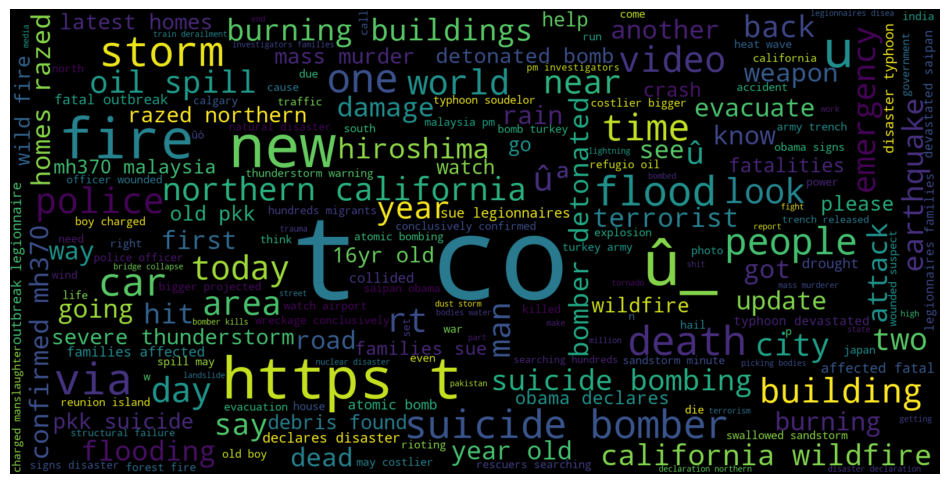

In [8]:
# Extrat the text with real Disaster
disaster_tweets = raw_tweets[raw_tweets.target == 1]
disaster_words = []
for tweet in disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        disaster_words.append(word)
disaster_words = pd.Series(disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


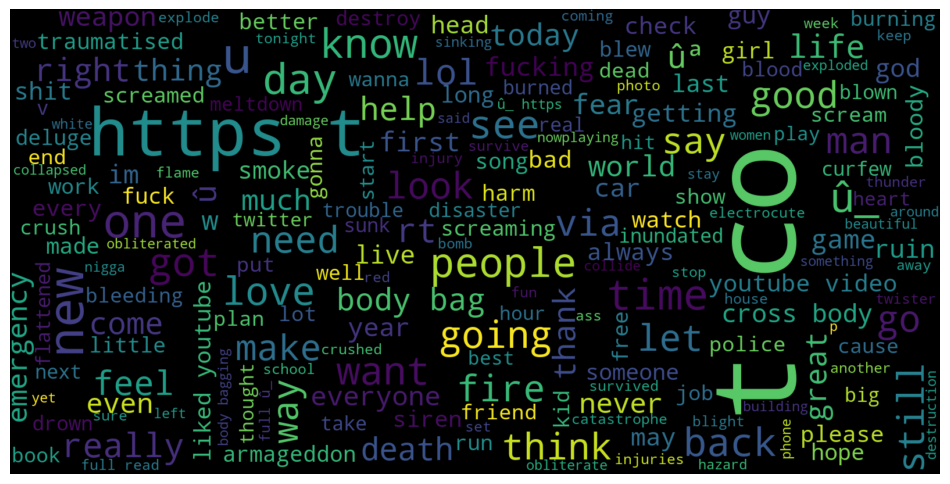

In [9]:
# Extrat the text with no real Disaster
not_disaster_tweets = raw_tweets[raw_tweets.target == 0]
not_disaster_words = []
for tweet in not_disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        not_disaster_words.append(word)
not_disaster_words = pd.Series(not_disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(not_disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Feature Engineering
In this section, we will explore multiple approaches:
- Bag-of-Words
- Ngram-of-Words
- Word Embeddings + Average across sentence

In [10]:
# CountVectorizer can be used to perform this action in normal text
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountVec.fit_transform(raw_tweets.text)
# However, this does not handle well the nuances of tweets
# We will create our own

<7613x21363 sparse matrix of type '<class 'numpy.int64'>'
	with 74103 stored elements in Compressed Sparse Row format>

In [11]:
def vectorize_tweet(tweet, vocab):
    '''
    This function puts 0 if the word is not present in tokens and count of token if present
    :param tweet: Specific tweet
    :param vocab: Seen vocab
    :return: BoW for this tweet
    '''
    vector=[]
    for w in vocab:
        vector.append(tweet.count(w))
    return vector

def get_vocab(all_tweets):
    '''
    This functions returns a list in which the order remains 
    same and no item repeats
    '''
    # Flatten list
    all_tweets_concat = [word for tweet in all_tweets for word in tweet]
    # Extract unique vocabulary
    seen = set()
    return [x for x in all_tweets_concat if not (x in seen or seen.add(x))]

In [12]:
# Extract unique vocabulary
vocab = get_vocab(raw_tweets.twitterTokens_Stem.tolist())

# Vectorize and create a training dataframe for this
BoW_tweets = raw_tweets.twitterTokens_Stem.progress_apply(vectorize_tweet, vocab=vocab)
BoW_tweets = pd.DataFrame(BoW_tweets.tolist(), columns=vocab)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [ ]:
# Create NGrams - TBD
# Generate Embeddings - TBD

# 4. Data Modeling

This section explores different architectures for text classification, ranging from Classic ML to RNN and CNN1D.